### Giving Life to Equations

#### Backpropagation from First Principles (Python/NumPy)

This notebook implements our multi-layer Perceptron and the learning process using only Python and the NumPy library to classify images of handwritten digits. The objective here is to see the theory and equations from Chapters 1, 2, and 3 as explicitly as possible.

Different from the example in the next chapter, here we:

1.  **Will not use a high-level framework** like TensorFlow for the training. All calculations will be done "by hand".
2.  **Will train with one vector at a time**, instead of batches (we will see all about this in Chapter <<train-in-batches>>).
3.  Will implement the calculation of the weights' gradient, mirroring as perfectly as possible the mathematical derivation we saw in this chapter for a single training example.

This is the foundation. By understanding this code, you will understand how modern frameworks use, _under the hood_, the theory we have presented.


#### Step 1: Preparing the Environment and Data

First, we prepare our environment and data. We will use `NumPy` for all our mathematical calculations and `Matplotlib` for visualization.

For convenience, we will use the `tensorflow` library *only once* to easily download the MNIST dataset (which contains the set of images with handwritten digits). After loading, all data will be NumPy arrays, and TensorFlow will no longer be used.

The preprocessing is identical to the next example: we normalize the pixels, "flatten" the images into vectors, and use _one-hot encoding_ for the desired responses.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # Used ONLY to conveniently load the dataset

# Load the MNIST dataset
(x_train, z_train), (x_test, z_test) = tf.keras.datasets.mnist.load_data()

# Function for one-hot encoding using only NumPy
def to_one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

# Preprocessing with NumPy
x_train = (x_train.astype("float32") / 255.0).reshape(60000, 784)
x_test = (x_test.astype("float32") / 255.0).reshape(10000, 784)

z_train_one_hot = to_one_hot(z_train).astype('float32')
z_test_one_hot = to_one_hot(z_test).astype('float32')

print("Data ready and in NumPy format!")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data ready and in NumPy format!


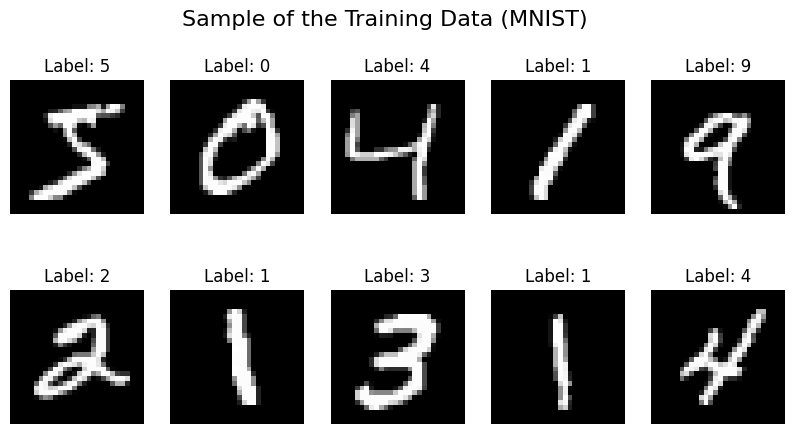

In [2]:
# Visualization code with Matplotlib
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {z_train[i]}") # We use the original z_train for the title
    plt.axis('off')
plt.suptitle("Sample of the Training Data (MNIST)", fontsize=16)
plt.show()

#### Step 2: Defining the Tools (Functions)

Since we are not using a model class like in Keras, we need to define all our "tools" as separate functions. Here, we will create the activation functions (ReLU and Sigmoid) and their respective derivatives, the cost function (Mean Squared Error) and its derivative, and a function to initialize the weights and biases of our network.

In [3]:
# Activation Functions and their derivatives
def relu(y):
    return np.maximum(0, y)

def relu_derivative(y):
    return np.where(y > 0, 1, 0)

def sigmoid(y):
    return 1 / (1 + np.exp(-y))

def sigmoid_derivative(a):
    return a * (1 - a)

# Cost Function and its derivative
def mean_squared_error(z, P):
    return np.mean((z - P)**2)

def mean_squared_error_derivative(z, P):
    return P - z

# Function to initialize the network's parameters
def initialize_parameters(layer_dims):
    W = {}
    b = {}
    for l in range(1, len(layer_dims)):
        # We initialize with small random values to break the symmetry
        W[l] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        b[l] = np.zeros((layer_dims[l], 1))
    return W, b

#### Step 3: Training with Manual Backpropagation

This is the central cell of our example. Here, we implement the learning process as presented in this chapter. The outer loop iterates through the "epochs" (full passes over the dataset), and the inner loop iterates over **each individual training example**.

For each image `x` and its label `z`:

1.  **Forward Pass:** We calculate the network's output `P` by passing `x` through all the layers, storing the intermediate values `y` and `a`.
2.  **Error Calculation:** We measure the error `E` of the prediction.
3.  **Backpropagation:** Starting from the last layer, we calculate the gradients `∂E/∂W` and `∂E/∂b` for each layer, mirroring the theory we presented as closely as possible.
4.  **Update:** We subtract a fraction of the gradient (controlled by the learning rate) from the current parameters, adjusting the network in the direction that minimizes the error.

In [4]:
# --- Hyperparameters and Architecture ---
learning_rate = 0.01
epochs = 5
# The architecture: input 784 (number of elements in vector x) -> 1st layer 128 neurons -> 2nd layer 64 neurons -> 3rd layer (output) 10 neurons
layer_dims = [784, 128, 64, 10]

# --- Initialization ---
W, b = initialize_parameters(layer_dims)
num_layers = len(layer_dims) - 1
cost_history = []

print("Starting the training in Python/NumPy...")
for i in range(epochs):
    total_epoch_cost = 0
    # The inner loop iterates over each example
    for x, z in zip(x_train, z_train_one_hot):
        # Reshape x and z to be column vectors
        x = x.reshape(-1, 1)
        z = z.reshape(-1, 1)

        # --- 1. Forward Pass ---
        activations = {'a0': x}
        linearities = {}

        a_previous = x
        for l in range(1, num_layers + 1):
            y = np.dot(W[l], a_previous) + b[l]
            linearities[f'y{l}'] = y

            if l == num_layers: # Last layer
                a = sigmoid(y)
            else: # Hidden layers
                a = relu(y)
            activations[f'a{l}'] = a
            a_previous = a

        P = activations[f'a{num_layers}']
        total_epoch_cost += mean_squared_error(z, P)

        # --- 2. Backpropagation ---
        # Gradients for the weights and biases
        dE_dW = {}
        dE_db = {}

        # Gradient 'Seed' (for the last layer L)
        dE_dP = mean_squared_error_derivative(z, P)
        dP_dyL = sigmoid_derivative(P)
        dE_dy = dE_dP * dP_dyL # Initial delta

        # Reverse Loop
        for l in reversed(range(1, num_layers + 1)):
            a_previous = activations[f'a{l-1}']

            # Gradients of layer 'l'
            # USING THE OUTER PRODUCT, AS IN THE THEORY!
            dE_dW[l] = np.outer(dE_dy, a_previous)
            dE_db[l] = dE_dy

            # Propagate the error to the previous layer (if it's not the first)
            if l > 1:
                y_previous = linearities[f'y{l-1}']
                dE_da_previous = np.dot(W[l].T, dE_dy)
                da_previous_dy_previous = relu_derivative(y_previous)
                dE_dy = dE_da_previous * da_previous_dy_previous

        # --- 3. Parameter Update ---
        for l in range(1, num_layers + 1):
            W[l] -= learning_rate * dE_dW[l]
            b[l] -= learning_rate * dE_db[l]

    # End of epoch
    average_cost = total_epoch_cost / len(x_train)
    cost_history.append(average_cost)
    print(f"Epoch {i + 1}/{epochs} - Average Cost: {average_cost:.6f}")

print("Training finished!")

Starting the training in Python/NumPy...
Epoch 1/5 - Average Cost: 0.066971
Epoch 2/5 - Average Cost: 0.014656
Epoch 3/5 - Average Cost: 0.008609
Epoch 4/5 - Average Cost: 0.006259
Epoch 5/5 - Average Cost: 0.005001
Training finished!


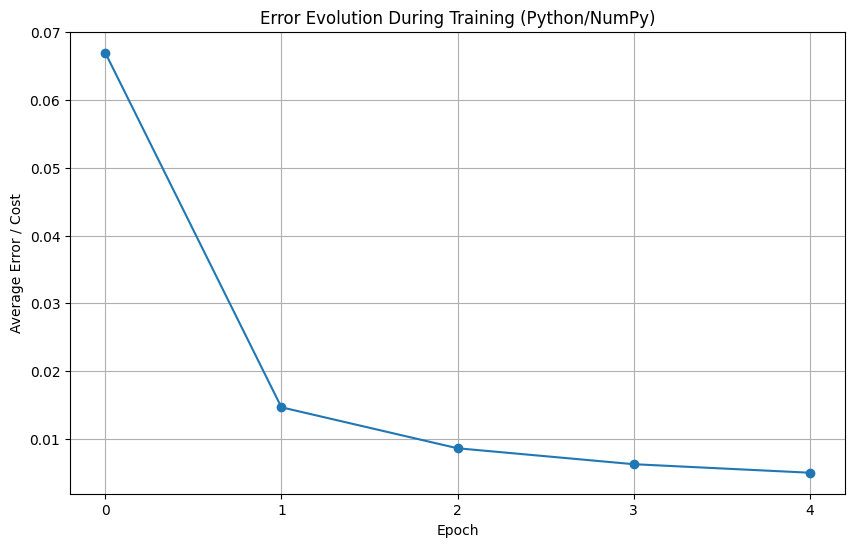

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Error / Cost")
plt.title("Error Evolution During Training (Python/NumPy)")
plt.grid(True)
plt.xticks(range(epochs))
plt.show()

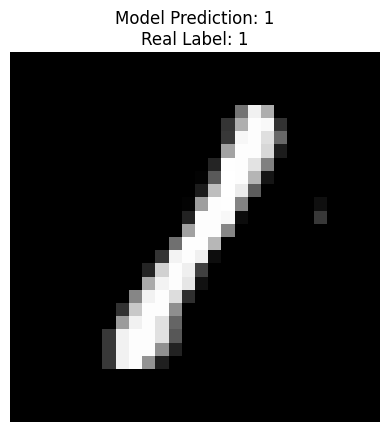

In [8]:
def forward_pass_test(x, W, b):
    a = x.reshape(-1, 1)
    num_layers = len(W)
    for l in range(1, num_layers + 1):
        y = np.dot(W[l], a) + b[l]
        if l == num_layers:
            a = sigmoid(y)
        else:
            a = relu(y)
    return a

def test_numpy_model():
    random_idx = np.random.randint(0, len(x_test))

    img = x_test[random_idx]
    real_label = z_test[random_idx] # We use the original z_test for the title

    prediction_vector = forward_pass_test(img, W, b)
    predicted_label = np.argmax(prediction_vector)

    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Model Prediction: {predicted_label}\nReal Label: {real_label}")
    plt.axis('off')
    plt.show()

# Execute this cell several times to test!
test_numpy_model()